In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%reload_ext autoreload

In [5]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")

# then move to feature extraction
os.chdir("feature_extraction")

print(os.getcwd())

/Users/supriyatno/codes/timescales_filtering/feature_extraction


In [6]:
from typing import Dict, List, Optional

from tqdm.notebook import trange, tqdm

import numpy as np

from scipy.signal import periodogram, welch

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from hard_coded_things import train_stories, test_stories

from signal_processing import upsample_story
from utils import get_dir
from hard_coded_things import frequency_to_period_name_dict


Using cpu


In [8]:
from config import config_plotting

In [9]:
config_plotting(context="paper", palette="muted")

In [10]:
fft_size = 1024
sr = 10

n_neurons = 9984

seed = 10

upsampling_method = "linear"
normalized_psd = True

is_chinese=False

aggregation_method = 'mean'

cache = ".cache/spectral_analysis/en"

In [11]:
if not os.path.exists(cache):
    os.makedirs(cache)

In [12]:
all_stories = train_stories + test_stories
grid_dir, trfile_dir = get_dir(is_chinese=is_chinese)

# Upsampling Stories

In [13]:

story_data_bert_en= {}
for s in all_stories:
    story_data_bert_en[s] = upsample_story(
        s,
        new_sr=sr,
        upsampling_method=upsampling_method,
        story_grid_dir=grid_dir,
        story_trfile_dir=trfile_dir,
        featureset_name="BERT_all",
        cache=cache
    )

In [14]:
story_data_mbert_en= {}
for s in all_stories:
    story_data_mbert_en[s] = upsample_story(
        s,
        new_sr=sr,
        upsampling_method=upsampling_method,
        story_grid_dir=grid_dir,
        story_trfile_dir=trfile_dir,
        featureset_name="mBERT_all",
        cache=cache
    )

# Spectral Density Analysis

In [15]:
def compute_psd_per_channel(story_data: dict, story_list: List = train_stories):
    n_neurons = story_data_bert_en[train_stories[0]]['story_data'].shape[1]
    psds = np.zeros((n_neurons, fft_size // 2 + 1))
    f = None
    for n in trange(n_neurons):
        # join for all stories
        joint_data = np.concatenate([story_data[s]['story_data'][:, n] for s in story_list])
        # compute periodogram
        f, psds[n] = welch(joint_data, fs=sr, nperseg=fft_size, return_onesided=True)
        # f, psds[n] = periodogram(joint_data, fs=sr, nfft=fft_size)
        
    return f, psds

In [16]:
f, bert_periodograms = compute_psd_per_channel(story_data_bert_en, story_list = train_stories)
f, mbert_periodograms = compute_psd_per_channel(story_data_mbert_en, story_list = train_stories)

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

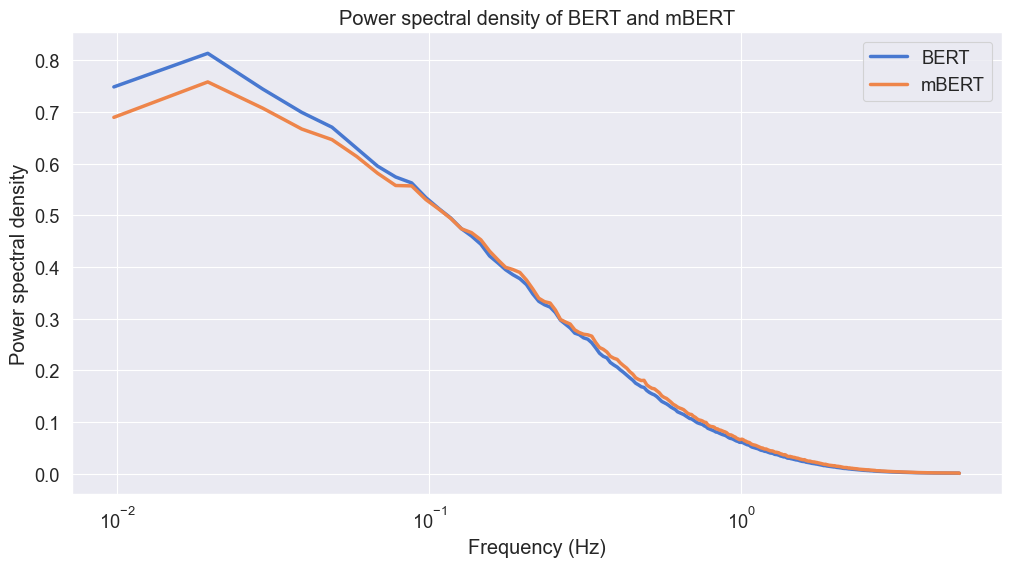

In [30]:
# plot PSDs for BERT and mBERT 
plt.figure(figsize=(12, 6))

plt.plot(f[1:], np.mean(bert_periodograms, axis=0)[1:], label="BERT")
plt.plot(f[1:], np.mean(mbert_periodograms, axis=0)[1:], label="mBERT")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density")
plt.title("Power spectral density of BERT and mBERT")

# log scale
plt.xscale("log")

plt.legend()
plt.show()
        

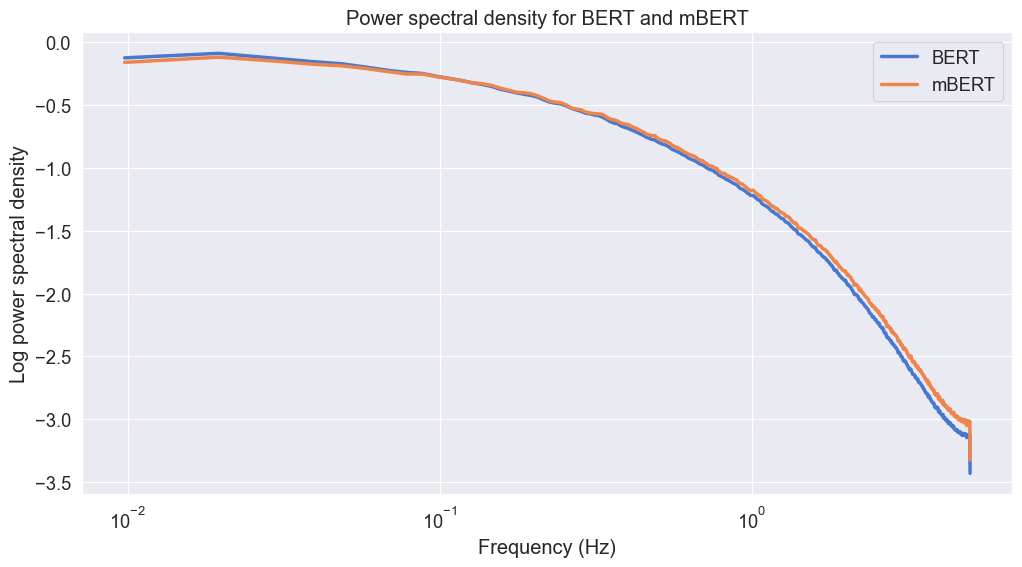

In [18]:
# plot PSDs for BERT and mBERT in dB scale
plt.figure(figsize=(12, 6))

plt.plot(f[1:], np.log10(np.mean(bert_periodograms, axis=0)[1:]), label="BERT")
plt.plot(f[1:], np.log10(np.mean(mbert_periodograms, axis=0)[1:]), label="mBERT")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Log power spectral density")

plt.title("Power spectral density of BERT and mBERT")

# log scale
plt.xscale("log")

plt.legend()

plt.show()


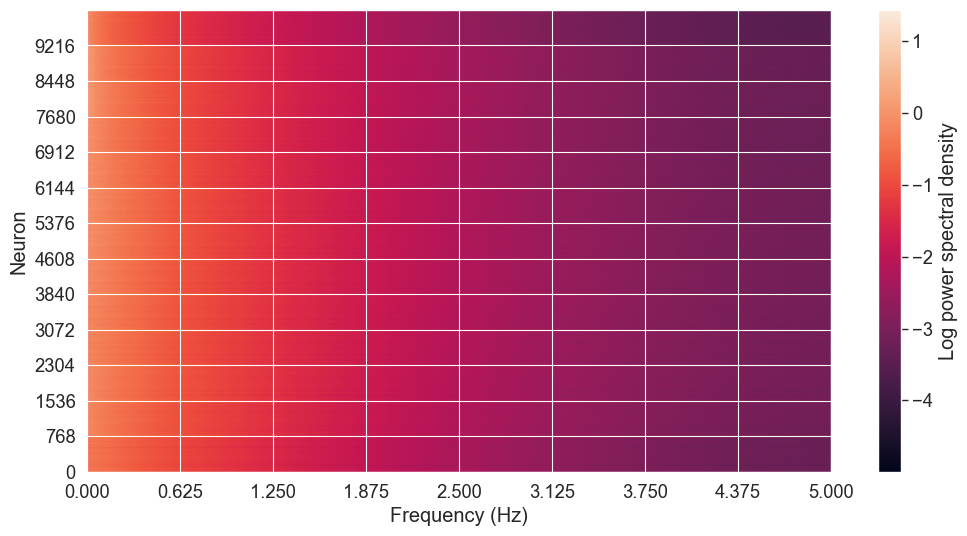

In [19]:
# plot psd imshow for BERT
plt.figure(figsize=(12, 6))

plt.imshow(np.log10(bert_periodograms), aspect='auto', origin='lower', extent=[f[0], f[-1], 0, bert_periodograms.shape[0]])
plt.ylabel("Neuron")
plt.xlabel("Frequency (Hz)")

# set ticks to f
plt.xticks(f[::64])

# set y ticks by range of 768
plt.yticks(np.arange(0, mbert_periodograms.shape[0], 768))

# add colorbar
plt.colorbar(label="Log power spectral density")


plt.show()

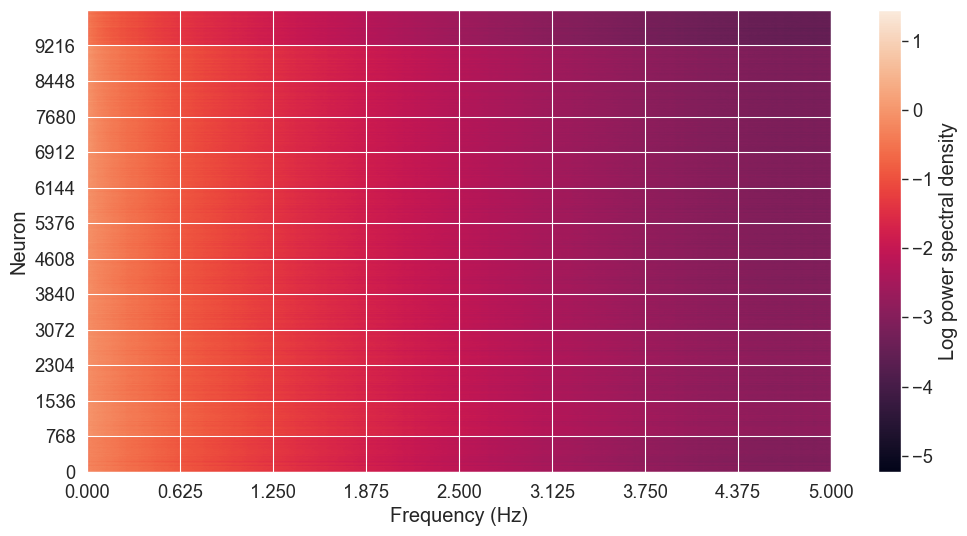

In [20]:
# now for mBERT
plt.figure(figsize=(12, 6))

plt.imshow(np.log10(mbert_periodograms), aspect='auto', origin='lower', extent=[f[0], f[-1], 0, mbert_periodograms.shape[0]])
plt.ylabel("Neuron")
plt.xlabel("Frequency (Hz)")

# set ticks to f
plt.xticks(f[::64])

# set y ticks by range of 768
plt.yticks(np.arange(0, mbert_periodograms.shape[0], 768))

plt.colorbar(label="Log power spectral density")


plt.show()

# Construct timescale feature

In [14]:
import pickle

from save_features import save_filtered_features, get_save_file_breakpoints, get_savename_template, 

In [15]:
save_file_breakpoints = get_save_file_breakpoints(n_neurons)


## Running filtering

In [ ]:
save_file_breakpoints = get_save_file_breakpoints(n_neurons)
featureset_names = ['mBERT_all', 'BERT_all']
lang='en'
# save filtered feature
for featureset_name in featureset_names:
    for story in all_stories:
        for breakpoint_start, breakpoint_end in zip(
            [0] + save_file_breakpoints[:-1], save_file_breakpoints
        ):
            save_dir = os.path.join('intermediate_outputs', featureset_name, lang)
            os.makedirs(save_dir, exist_ok=True)
            
            save_filtered_features(
                story,
                featureset_name=featureset_name,
                num_neurons=n_neurons,
                neuron_index_range=range(breakpoint_start, breakpoint_end),
                story_grid_dir=grid_dir,
                story_trfile_dir=trfile_dir,
                save_dir = save_dir,
            )

## grouping features

In [21]:
def save_timescale_feature(feature_set_name='mBERT_all', lang='zh', save_dir="timescale_features", stories: List[str] = all_stories):
    feature_save_dir = os.path.join(save_dir, feature_set_name, lang)
    os.makedirs(feature_save_dir, exist_ok=True)
    
    filtered_data = {}
    for story in stories:
        temps = []
        for breakpoint_start, breakpoint_end in zip(
            [0] + save_file_breakpoints[:-1], save_file_breakpoints
        ):
            save_dir = os.path.join('intermediate_outputs', feature_set_name, lang)

            with open(
                get_savename_template(
                    story_name = story,
                    neuron_index_range=range(breakpoint_start, breakpoint_end),
                    featureset_name = feature_set_name,
                    step_name='filter',
                    save_filepath = save_dir,
                ), 'rb'
            ) as f:
                filtered_stimulus_band = pickle.load(f)
                temps.append(filtered_stimulus_band)
            
        filtered_data[story] = temps.copy()
    # joint all features
    freqs = list(frequency_to_period_name_dict.keys())

    for story in list(filtered_data.keys()):
        story_data = filtered_data[story]
        chunks = len(story_data)
        timescale = {}
        for i, freq in enumerate(freqs):
            timescale[str(freq)] = np.concatenate([story_data[j][freq] for j in range(chunks)], axis=1).T
            
        save_path = os.path.join(feature_save_dir, f'{story}.npz')
        
        np.savez_compressed(save_path, **timescale)


In [22]:
save_timescale_feature(feature_set_name='mBERT_all', lang='en', stories=all_stories)

save_timescale_feature(feature_set_name='BERT_all', lang='en', stories=all_stories)

# Fitting linear model

In [22]:
import pandas as pd

from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.scoring import r2_score

from sklearn import model_selection

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
timescale_feature_dir = 'timescale_features'

lang='en'

story = all_stories[0]

In [24]:
def timescale_regression_analysis(
    target_featureset_name: str,
    input_featureset_name: str,
    lang: str,
    story: str
):
    target_dir = os.path.join(timescale_feature_dir, target_featureset_name, lang)
    input_dir = os.path.join(timescale_feature_dir, input_featureset_name, lang)
    
    target_data = np.load(os.path.join(target_dir, f'{story}.npz'))
    input_data = np.load(os.path.join(input_dir, f'{story}.npz'))
    
    fcs = list(frequency_to_period_name_dict.keys())

    timescale_scores = {}
    for fc in fcs:                
        X = target_data[str(fc)].T
        Y = input_data[str(fc)].T
        
        if np.allclose(X, Y):
            print('target and input are the same')
            break

        # spliting data
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2,random_state=seed)

        model = KernelRidgeCV(
            kernel='linear',
            alphas=np.logspace(-2, 2, 11)
        )

        model.fit(X_train, Y_train)
        
        Y_test_pred = model.predict(X_test)

        # compute r2
        scores = r2_score(Y_test, Y_test_pred)
        
        stat = {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        timescale_scores[frequency_to_period_name_dict[fc]] = stat
    
    return timescale_scores
    

In [25]:
timescale_stats = timescale_regression_analysis(
    target_featureset_name = 'mBERT_all',
    input_featureset_name = 'BERT_all',
    lang = lang,
    story = story
)

In [26]:
# rev_timescale_stats = timescale_regression_analysis(
#     target_featureset_name = 'BERT_all',
#     input_featureset_name = 'mBERT_all',
#     lang = lang,
#     story = story
# )

In [27]:
timescale_stats = pd.DataFrame(timescale_stats)

## plotting

In [28]:
timescale_stats

,2_4_words,4_8_words,8_16_words,16_32_words,32_64_words,64_128_words,128_256_words,256+ words
mean,0.926101,0.999599,0.999995,9.999987e-01,9.999993e-01,9.999995e-01,9.999996e-01,9.999999e-01
std,0.045920,0.000344,0.000002,4.117787e-07,2.096296e-07,1.696752e-07,2.117658e-07,5.783831e-08


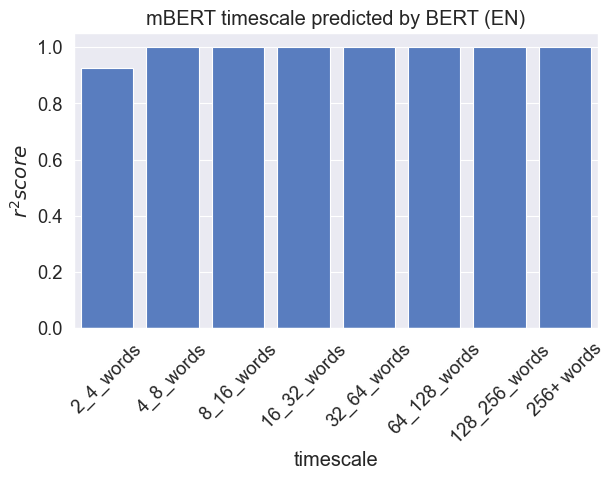

In [29]:
# plot mean barplot
sns.barplot(x=timescale_stats.columns, y=timescale_stats.loc['mean'])

# tilt xlabel
plt.xticks(rotation=45)
plt.xlabel('timescale')
plt.ylabel(r'$r^2 score$')

plt.tight_layout()

plt.title('mBERT timescale predicted by BERT (EN)')
plt.show()